In [66]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city

In [67]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
import random
from cmath import *


In [151]:
def get_random_state():
    theta = np.pi*random.random()
    phi = 2*np.pi*random.random()

    a = np.cos(theta/2)
    b = rect(1,phi)*np.sin(theta/2)
    
    return a, b


In [152]:
## figure out how to get random numbers
a0,b0 = get_random_state()

q = QuantumRegister(2, "q")
c0 = ClassicalRegister(1, "c0")
c1 = ClassicalRegister(1, "c1")
qc = QuantumCircuit(q, c0, c1, name="teleport")

# Create initial state
# opts = {"initial_statevector": np.array([a0, 0, b0, 0])}
#opts = {"initial_statevector": np.array([1, 0, 1, 0] / np.sqrt(2))}

qc.x(q[0])

qc.cx(q[0], q[1])
qc.h(q[0])

qc.barrier(q)
qc.measure(q[0], c0[0])

qc.barrier(q)
qc.z(q[1]).c_if(c0, 1)

qc.measure(q[1], c1[0])

print(qc.draw())

        ┌───┐     ┌───┐ ░ ┌─┐ ░           
q_0: |0>┤ X ├──■──┤ H ├─░─┤M├─░───────────
        └───┘┌─┴─┐└───┘ ░ └╥┘ ░ ┌─────┐┌─┐
q_1: |0>─────┤ X ├──────░──╫──░─┤  Z  ├┤M├
             └───┘      ░  ║  ░ ├──┴──┤└╥┘
c0_0: 0 ═══════════════════╩════╡ = 1 ╞═╬═
                                └─────┘ ║ 
c1_0: 0 ════════════════════════════════╩═
                                          


0.2980358060634901 (0.8667237150255956+0.3999558227058532j)


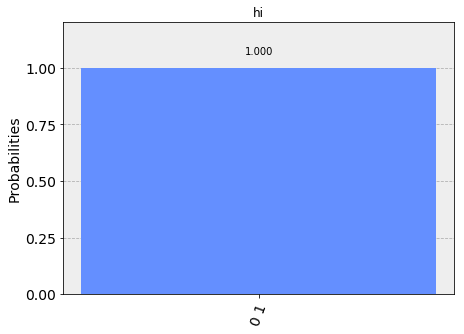

In [153]:
# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
'''result = execute(circ, simulator, backend_options=opts).result()
statevector = result.get_statevector(circ)
plot_state_city(statevector, title="Bell initial statevector")'''

print(a0,b0)
result = execute(qc, simulator, backend_options=opts).result()
counts = result.get_counts(qc)
plot_histogram(counts, title="hi")


In [10]:
# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel

# Import all standard errors
from qiskit.providers.aer.noise.errors import *  

# Import noise base clases
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError
from qiskit.providers.aer.noise.errors.readout_error import ReadoutError

In [18]:
def ampdamp(lamb, p1):
    error = amplitude_damping_error(lamb, p1)
    return error


In [19]:
# Create an empty noise model
noise_model = NoiseModel()

ampdamp = ampdamp(0.5,1)

# Add depolarizing error to all single qubit u1, u2, u3 gates
noise_model.add_all_qubit_quantum_error(ampdamp, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)


NoiseModel:
  Instructions with noise: ['u2', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


In [22]:
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 1
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit

num_gates = 10 # an even number

for i in range(num_gates):
    circ.h(qr[0])
circ.measure(qr, cr)
print(circ.draw())

         ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q1_0: |0>┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤M├
         └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└╥┘
 c1_0: 0 ═══════════════════════════════════════════════════╩═
                                                              


In [30]:
aggreg = {0:"hi"}
aggreg[0]

'hi'

In [37]:
from qiskit_chemistry import FermionicOperator
from qiskit_chemistry.drivers import PySCFDriver, UnitsType

# Use PySCF, a classical computational chemistry software package, to compute the one-body and two-body integrals in
# molecular-orbital basis, necessary to form the Fermionic operator
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735',
                    unit=UnitsType.ANGSTROM,
                    basis='sto3g')
molecule = driver.run()
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

# Build the qubit operator, which is the input to the VQE algorithm in Aqua
ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
map_type = 'PARITY'
qubitOp = ferOp.mapping(map_type)
qubitOp = qubitOp.two_qubit_reduced_operator(num_particles)
num_qubits = qubitOp.num_qubits

# set the backend for the quantum computation
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

# setup a classical optimizer for VQE
from qiskit.aqua.components.optimizers import L_BFGS_B
optimizer = L_BFGS_B()

# setup the initial state for the variational form
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock
init_state = HartreeFock(num_qubits, num_spin_orbitals, num_particles)

# setup the variational form for VQE
from qiskit.aqua.components.variational_forms import RYRZ
var_form = RYRZ(num_qubits, initial_state=init_state)

# setup and run VQE
from qiskit.aqua.algorithms import VQE
algorithm = VQE(qubitOp, var_form, optimizer)
result = algorithm.run(backend)
print(result['energy'])

NameError: name 'param' is not defined